# Step Length Distribution Analysis

Run simulations on different agent types and collect their step lengths. 
Then analyse whether any of them follow power law distribution. 

Note:
Because we select the step lengths from the agents only a single iteration is used.
This can be balanced by using more agents or a higher total_time.


In [1]:
import os
os.chdir(os.path.join(os.getcwd(), "../code"))
import numpy as np
from parameters import Params
from simulation import Simulation
import matplotlib.pyplot as plt
from agent import ReservoirAgent, BrownianAgent, LévyAgent, ExponentialAgent
from environment import Environment
import powerlaw
from tqdm import tqdm

tolerance = 0.02

params = Params.from_json('parameters.json')
params.save = False
params.iterations_per_epoch = 1
data = []
environment = Environment(params)

# Reservoir Agent
### Critical and Chaotic

In [2]:
params.type = 'reservoir'
params.agent = ReservoirAgent

params.standard_deviation = 0.032
sim = Simulation(params, params.agent)
population = sim.run_epoch(sim.set_up_population(None), environment)
step_lengths = np.array([])
for agent in population:
    step_counter = 1
    for output in agent.output_log:
        if abs(output) > 1 - tolerance or abs(output) < tolerance:
            step_counter += 1
        else:
            step_lengths = np.append(step_lengths, step_counter)
            step_counter = 1
data.append(step_lengths)

params.standard_deviation = 0.1
sim = Simulation(params, params.agent)
population = sim.run_epoch(sim.set_up_population(None), environment)
step_lengths = np.array([])
for agent in population:
    step_counter = 1
    for output in agent.output_log:
        if abs(output) > 1 - tolerance or abs(output) < tolerance:
            step_counter += 1
        else:
            step_lengths = np.append(step_lengths, step_counter)
            step_counter = 1
data.append(step_lengths)

# Lévy Agent

In [3]:
params.type = 'levy'
params.agent = LévyAgent
sim = Simulation(params, params.agent)
population = sim.run_epoch(sim.set_up_population(None), environment)
step_lengths = np.array([])
for agent in population:
    step_lengths = np.concatenate((step_lengths, agent.step_length_log))
data.append(step_lengths)

# Exponential Agent

In [4]:
params.type = 'exponential'
params.agent = ExponentialAgent
sim = Simulation(params, params.agent)
population = sim.run_epoch(sim.set_up_population(None), environment)
step_lengths = np.array([])
for agent in population:
    step_lengths = np.concatenate((step_lengths, agent.step_length_log))
data.append(step_lengths)

# Brownian Agent

In [5]:
params.type = 'brownian'
params.agent = BrownianAgent
sim = Simulation(params, params.agent)
population = sim.run_epoch(sim.set_up_population(None), environment)
step_lengths = np.array([])
for agent in population:
    step_lengths = np.concatenate((step_lengths, agent.step_length_log))
data.append(step_lengths)

# Visualization

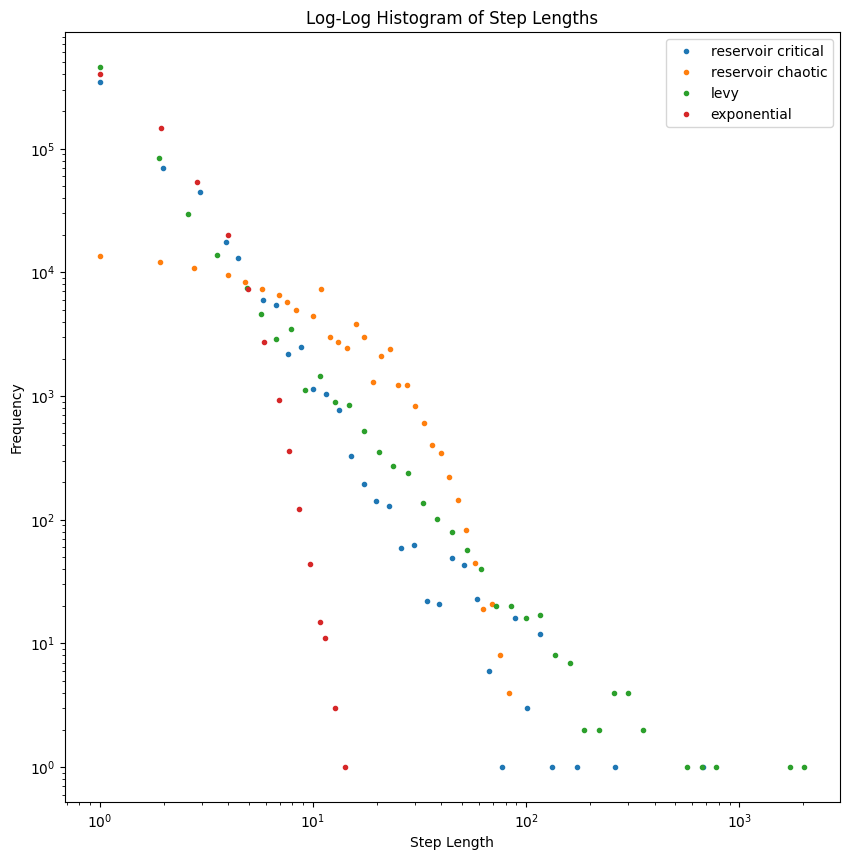

In [6]:
counts_0, bins_0 = np.histogram(data[0], bins=np.logspace(np.log10(min(data[0])), np.log10(max(data[0])), 50))
counts_1, bins_1 = np.histogram(data[1], bins=np.logspace(np.log10(min(data[1])), np.log10(max(data[1])), 50))
counts_2, bins_2 = np.histogram(data[2], bins=np.logspace(np.log10(min(data[2])), np.log10(max(data[2])), 50))
counts_3, bins_3 = np.histogram(data[3], bins=np.logspace(np.log10(min(data[3])), np.log10(max(data[3])), 50))
counts_4, bins_4 = np.histogram(data[4], bins=np.logspace(np.log10(min(data[4])), np.log10(max(data[4])), 50))

plt.figure(figsize = (10,10))
plt.loglog(bins_0[:-1], counts_0, marker='.', linestyle='none', label='reservoir critical')
plt.loglog(bins_1[:-1], counts_1, marker='.', linestyle='none', label='reservoir chaotic')
plt.loglog(bins_2[:-1], counts_2, marker='.', linestyle='none', label='levy')
plt.loglog(bins_3[:-1], counts_3, marker='.', linestyle='none', label='exponential')
# plt.loglog(bins_4[:-1], counts_4, marker='.', linestyle='none', label='brownian')

plt.xlabel('Step Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Log-Log Histogram of Step Lengths')
plt.show()

# Figure out $\mu$

In [7]:
assert(min(data[0]) == 1)
assert(min(data[2]) == 1)

fit_critical_reservoir = powerlaw.Fit(data[0], xmin=1, discrete=True)
fit_levy = powerlaw.Fit(data[2], xmin=1, discrete=True)

print(f"alpha: {fit_critical_reservoir.alpha:.2f}")
print(f"alpha: {fit_levy.alpha:2f}")

alpha: 1.95
alpha: 2.044751


# How Does $\mu$ Depend on $\sigma$?

In [8]:
params.type = 'reservoir'
params.agent = ReservoirAgent
params.population_size = 50

sigma_range = np.arange(0.03, 0.04, 0.0002)
data = []

for sigma in tqdm(sigma_range):
    params.standard_deviation = sigma
    sim = Simulation(params, params.agent)
    population = sim.run_epoch(sim.set_up_population(None), environment)
    step_lengths = np.array([])
    for agent in population:
        step_counter = 1
        for output in agent.output_log:
            if abs(output) > 1 - tolerance or abs(output) < tolerance:
                step_counter += 1
            else:
                step_lengths = np.append(step_lengths, step_counter)
                step_counter = 1
    data.append(step_lengths)


100%|██████████| 51/51 [08:49<00:00, 10.38s/it]


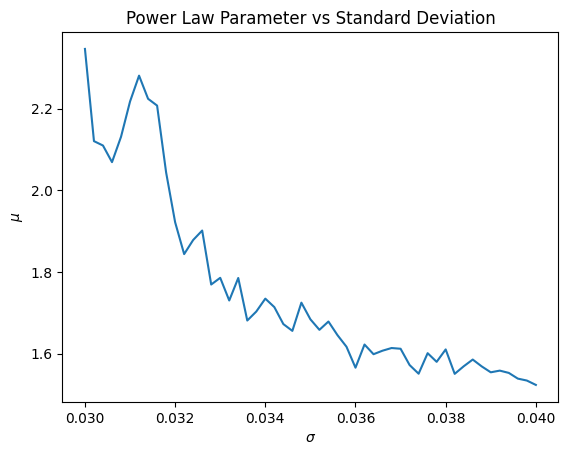

In [9]:
mu_values = []

for i in range(len(data)):
    fit = powerlaw.Fit(data[i], xmin=1, discrete=True)
    mu_values.append(fit.alpha)

plt.plot(sigma_range, mu_values)
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\mu$')
plt.title('Power Law Parameter vs Standard Deviation')
plt.show()